<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras import layers
import tensorflow as tf

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

In [3]:
! wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2025-04-15 15:56:59--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc’

current_SP3hourly_2 100%[===================>] 104.33M   691KB/s    in 2m 27s  

2025-04-15 15:59:27 (727 KB/s) - ‘current_SP3hourly_20110427.nc’ saved [109400556/109400556]



In [4]:
# import dataset (netcdf)
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [5]:
ds

<xarray.Dataset> Size: 109MB
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime      (starttime) float64 18kB ...
    x_speed      (starttime) int64 18kB ...
    y_speed      (starttime) int64 18kB ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 9MB ...
    uh03_grid    (starttime, y, x) float32 9MB ...
    ctt_grid     (starttime, y, x) float32 9MB ...
    dbz_grid     (starttime, y, x) float32 9MB ...
    mask         (starttime, y, x) int64 18MB ...
    row_indices  (starttime, y, x) int64 18MB ...
    col_indices  (starttime, y, x) int64 18MB ...
    lats         (starttime, y, x) float32 9MB ...
    lons         (starttime, y, x) float32 9MB ...

## ANN Autoencoder

We will again use the previous data, but this time we will focus on reconstructing one input variable (feature).

In [6]:
# selecting a variable
ds['dbz_grid']

<xarray.DataArray 'dbz_grid' (starttime: 2224, y: 32, x: 32)> Size: 9MB
[2277376 values with dtype=float32]
Coordinates:
  * starttime  (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime    (starttime) float64 18kB ...
    x_speed    (starttime) int64 18kB ...
    y_speed    (starttime) int64 18kB ...
Dimensions without coordinates: y, x

In [7]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].stack(new_dim=(["y", "x"])).values
print(features_data.shape)

(2224, 1024)


In [8]:
features_data.shape

(2224, 1024)

In [9]:
# split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    features_data,
    features_data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [10]:
# now rescale your data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # input
X_test = scaler.transform(X_test) # input
y_train = scaler.transform(y_train) # label
y_test = scaler.transform(y_test) # label

In [11]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1556, 1024) (668, 1024) (1556, 1024) (668, 1024)


## A simple autoencoder can be constructed as typical NNs, by adding sequential layers:

In [12]:
# create fully connected autoencoder
model = keras.Sequential()

# input
model.add(keras.Input(shape=(1024,))) # features

# encoder
# hidden layers
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))

# desired dimensions
model.add(layers.Dense(2, activation="relu"))

# decoder
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# Finally, we add last layer
model.add(layers.Dense(1024, activation='linear')) # back to the original shape

# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │        33,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,186 (262.45 KB)

 Trainable params: 67,186 (262.45 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
    keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
    keras.metrics.R2Score()
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
# train the NN now
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.8879 - mean_absolute_error: 0.7422 - mean_absolute_percentage_error: 424.9009 - mean_squared_error: 0.8879 - r2_score: 0.0847 - root_mean_squared_error: 0.9417 - val_loss: 0.7432 - val_mean_absolute_error: 0.7084 - val_mean_absolute_percentage_error: 222.2127 - val_mean_squared_error: 0.7432 - val_r2_score: 0.2861 - val_root_mean_squared_error: 0.8621
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6861 - mean_absolute_error: 0.6727 - mean_absolute_percentage_error: 660.0444 - mean_squared_error: 0.6861 - r2_score: 0.2912 - root_mean_squared_error: 0.8283 - val_loss: 0.7095 - val_mean_absolute_error: 0.6878 - val_mean_absolute_percentage_error: 251.3514 - val_mean_squared_error: 0.7095 - val_r2_score: 0.3200 - val_root_mean_squared_error: 0.8423
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6510 - mean_absolute_error: 0.6475 - mean_absolute_percentage_error: 671.1599 - mean_squared_error: 0.6510 - r2

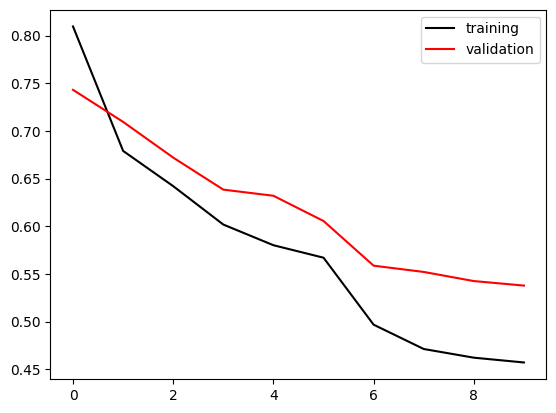

In [15]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

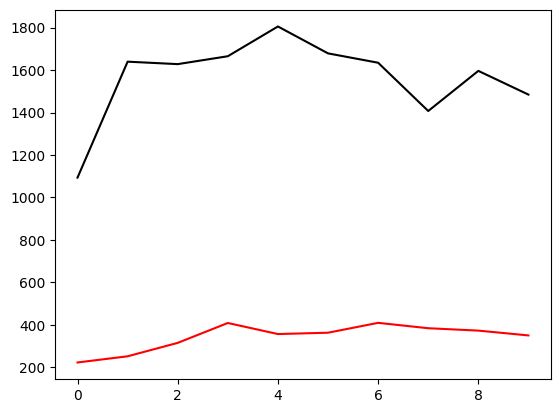

In [16]:
# visualize training and validation curves
plt.plot(history.history["mean_absolute_percentage_error"], c='k')
plt.plot(history.history["val_mean_absolute_percentage_error"], c='r')
plt.show()

In [17]:
# evaluation mode
y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [18]:
# check prediction shape matches test data shape
y_pred.shape

(668, 1024)

In [19]:
y_test.shape

(668, 1024)

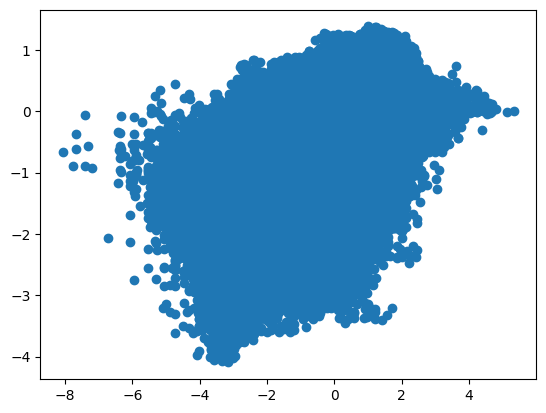

In [20]:
# visualize obs (x-axis) to nn predictions (y-axis)
plt.scatter(y_test, y_pred)
plt.show()

In [21]:
# evaluations (MSE)
mean_squared_error(y_test, y_pred)

0.7701334953308105

In [22]:
# to extract model layers, we can first print out model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │        33,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,560 (787.35 KB)

 Trainable params: 67,186 (262.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 134,374 (524.90 KB)

In [23]:
# model layers are contained as a list
model.layers

[<Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>,
 <Dense name=dense_4, built=True>,
 <Dense name=dense_5, built=True>]

In [24]:
# lets select the first layer
model.layers[0].input

<KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor>

In [25]:
# and the bottleneck layer
model.layers[1].output

<KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_3>

In [26]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[2].output
    )

In [27]:
# input test data into the bottleneck function
bottleneck_output = bottleneck(X_test)

In [28]:
X_test.shape

(668, 1024)

In [29]:
bottleneck_output.shape

TensorShape([668, 2])

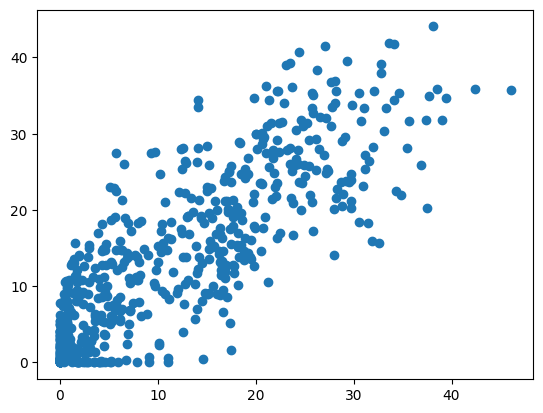

In [30]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()

In [31]:
# saving model
model.save('autoencodersample.keras')

In [32]:
# loading model
model2 = keras.models.load_model('autoencodersample.keras')

In [33]:
# inference with loaded model
ypred2 = model2.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


We can use autoencoders for the task of anomaly detection. For anomaly detection, we would note instances where reconstruction error for an image is higher, indicating that the sample was likely not similar to those in the training set distribution.

The prediction loss threshold for 2% of outliers is 1.14


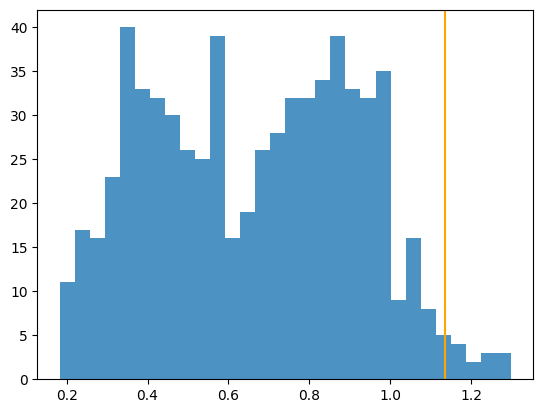

In [34]:
# for get the mean absolute error between actual and reconstruction/prediction
#prediction_loss = keras.losses.mae(ypred2, y_test)
MAE = keras.losses.MeanAbsoluteError(
    reduction=tf.keras.losses.Reduction.NONE,
    name="mean_absolute_error",
    dtype=None
)
prediction_loss = MAE(ypred2, y_test)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

The prediction loss threshold for 2% of outliers is 21.88


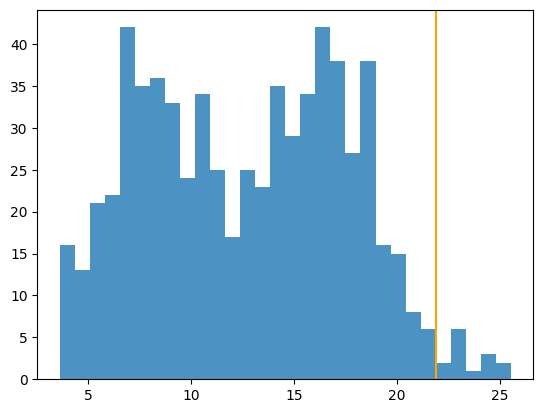

In [35]:
# same as above but for inverse transformed data
# for get the mean absolute error between actual and reconstruction/prediction
rescaled_pred = scaler.inverse_transform(ypred2)
rescaled_test = scaler.inverse_transform(X_test)

prediction_loss = MAE(rescaled_pred, rescaled_test)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

## We can also build AEs as two models, an Encoder and Decoder

In [36]:
encoder = keras.Sequential([
    layers.Dense(32, activation='relu'), # Input layer
    layers.Dense(8, activation='relu'),
    layers.Dense(2, activation='relu') # Latent space representation
], name='encoder')

In [37]:
decoder = keras.Sequential([
    layers.Dense(8, activation='relu'), # Input is latent representation
    layers.Dense(32, activation='relu'),
    layers.Dense(1024, activation='sigmoid') # Output layer, sigmoid for values between 0 and 1
], name='decoder')

In [38]:
autoencoder_input = keras.Input(shape=(1024,))
encoded_representation = encoder(autoencoder_input)

In [39]:
decoded_representation = decoder(encoded_representation)

In [40]:
autoencoder = keras.Model(autoencoder_input, decoded_representation, name='autoencoder')

In [41]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
    keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
    keras.metrics.R2Score()
]

# compile your nn
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 32
EPOCHS = 10

In [42]:
# train the NN now
history = autoencoder.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.1345 - mean_absolute_error: 0.7506 - mean_absolute_percentage_error: 443.0332 - mean_squared_error: 1.1345 - r2_score: -0.1692 - root_mean_squared_error: 1.0644 - val_loss: 0.9542 - val_mean_absolute_error: 0.7287 - val_mean_absolute_percentage_error: 370.8423 - val_mean_squared_error: 0.9542 - val_r2_score: 0.0936 - val_root_mean_squared_error: 0.9768
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8607 - mean_absolute_error: 0.6661 - mean_absolute_percentage_error: 279.7481 - mean_squared_error: 0.8607 - r2_score: 0.1138 - root_mean_squared_error: 0.9276 - val_loss: 0.9366 - val_mean_absolute_error: 0.7250 - val_mean_absolute_percentage_error: 284.2761 - val_mean_squared_error: 0.9366 - val_r2_score: 0.1112 - val_root_mean_squared_error: 0.9678
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8469 - mean_absolute_error: 0.6600 - mean_absolute_percentage_error: 248.8780 - mean_squared_error: 0.8469 - r

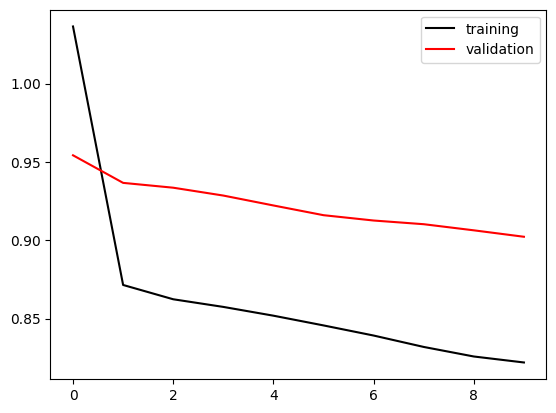

In [43]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

## CNN Autoencoder

In [44]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [45]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].values
print(features_data.shape)

(2224, 32, 32)


In [46]:
X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

In [47]:
X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

In [48]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [49]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, 1)))  # 32x32 images

# encoder
# hidden layers
model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

# decoder
model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

# Finally, we add last layer
model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))

# print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 4)        │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 4)        │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369 (13.16 KB)

 Trainable params: 3,369 (13.16 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [51]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.7636 - mean_squared_error: 0.7636 - root_mean_squared_error: 0.8730 - val_loss: 0.5431 - val_mean_squared_error: 0.5431 - val_root_mean_squared_error: 0.7370
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.3685 - mean_squared_error: 0.3685 - root_mean_squared_error: 0.6067 - val_loss: 0.3919 - val_mean_squared_error: 0.3919 - val_root_mean_squared_error: 0.6260
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2694 - mean_squared_error: 0.2694 - root_mean_squared_error: 0.5190 - val_loss: 0.3520 - val_mean_squared_error: 0.3520 - val_root_mean_squared_error: 0.5933
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.2356 - mean_squared_error: 0.2356 - root_mean_squared_error: 0.4853 - val_loss: 0.3259 - val_mean_squared_error: 0.3259 - val_root_mean_squared_error: 0.5709
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.2190 - mean_squared_error: 0.2190 - root_mean_squared_error: 0.

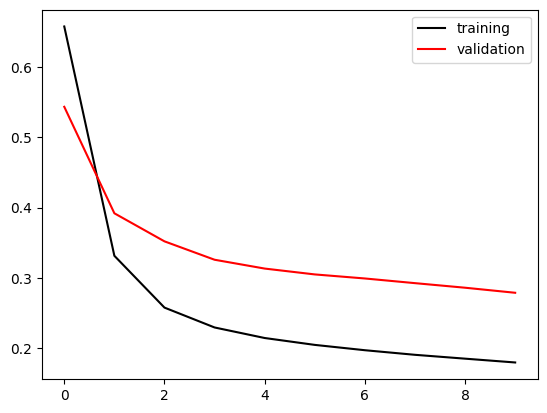

In [52]:
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [53]:
# saving model
model.save('autoencodercnn.keras')

# loading model
model2 = keras.models.load_model('autoencodercnn.keras')

In [54]:
# inference with loaded model
ypred2 = model2.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [55]:
print(y_test.shape, ypred2[:,:,:,0].shape)

(424, 32, 32) (424, 32, 32)


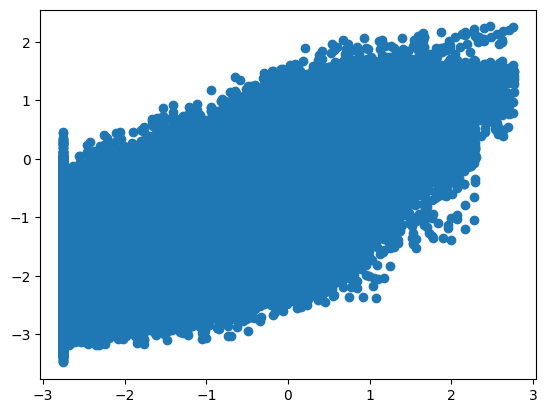

In [56]:
# evaluations
plt.scatter(np.ndarray.flatten(y_test), np.ndarray.flatten(ypred2[:,:,:,0]))
plt.show()

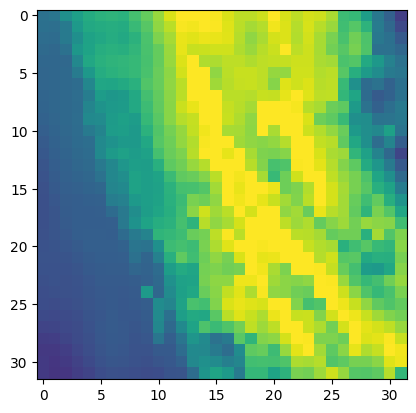

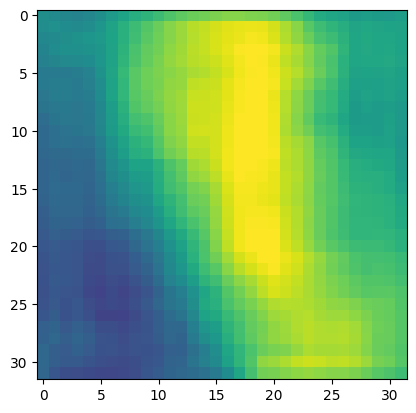

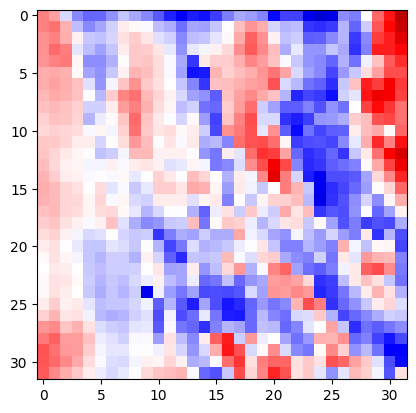

In [57]:
# evaluations
sample_indx = 15

plt.imshow(y_test[sample_indx,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred2[sample_indx,:,:,0], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred2[sample_indx,:,:,0] - y_test[sample_indx,:,:], cmap='seismic', vmin=-1, vmax=1)
plt.show()

In [58]:
# evaluations (MSE)
mean_squared_error(np.ndarray.flatten(y_test), np.ndarray.flatten(ypred2[:,:,:,0]))

0.37279200553894043

## CNN Autoencoder Noise Removal

In [59]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [60]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].values
print(features_data.shape)

X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2224, 32, 32)
(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [61]:
# Create a copy of the data with added noise
noisy_train_data = noise(X_train)
noisy_test_data = noise(X_test)

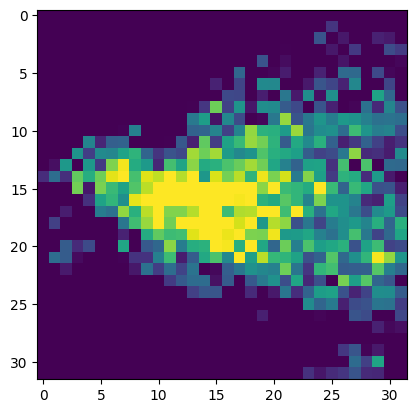

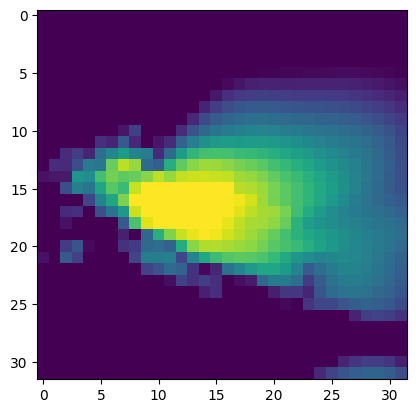

In [62]:
plt.imshow(noisy_train_data[0,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(X_train[0,:,:], vmin=-1, vmax=1)
plt.show()

In [63]:
# loading model
model_transfer = keras.models.load_model('autoencodercnn.keras')

In [64]:
model_transfer

<Sequential name=sequential_1, built=True>

In [65]:
history = model_transfer.fit(
    x=noisy_train_data,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.1861 - mean_squared_error: 0.1861 - root_mean_squared_error: 0.4314 - val_loss: 0.2754 - val_mean_squared_error: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1760 - mean_squared_error: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.2685 - val_mean_squared_error: 0.2685 - val_root_mean_squared_error: 0.5182
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1716 - mean_squared_error: 0.1716 - root_mean_squared_error: 0.4142 - val_loss: 0.2628 - val_mean_squared_error: 0.2628 - val_root_mean_squared_error: 0.5126
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1678 - mean_squared_error: 0.1678 - root_mean_squared_error: 0.4096 - val_loss: 0.2574 - val_mean_squared_error: 0.2574 - val_root_mean_squared_error: 0.5073
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1640 - mean_squared_error: 0.1640 - root_mean_squared_error: 0.

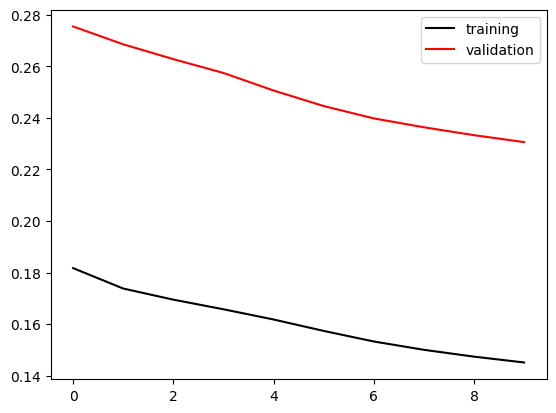

In [66]:
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [67]:
# inference with model
ypred = model_transfer.predict(noisy_test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


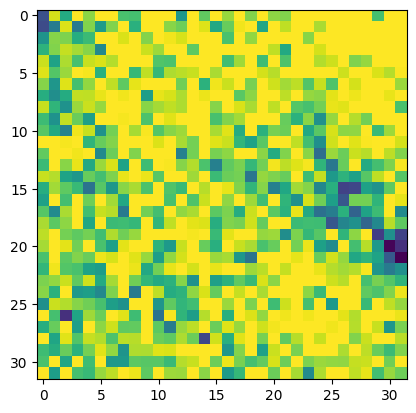

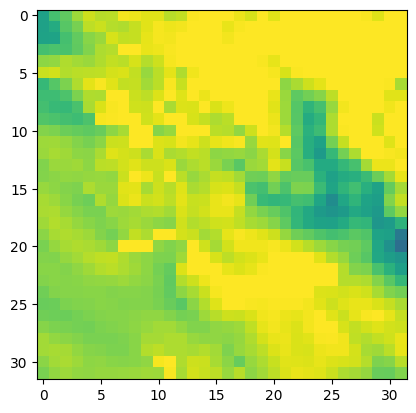

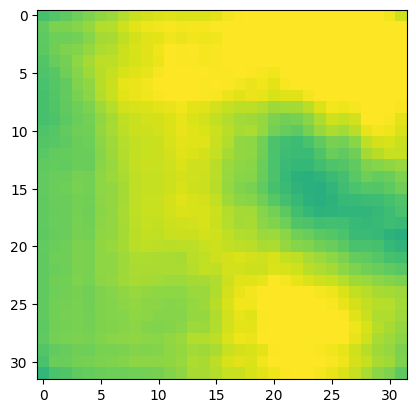

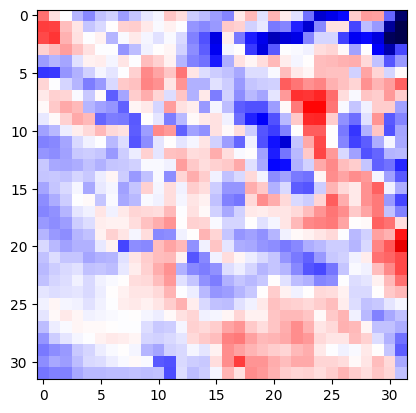

In [68]:
# evaluations
sample_indx = 42

plt.imshow(noisy_test_data[sample_indx, :, :], vmin=-1, vmax=1)
plt.show()

plt.imshow(y_test[sample_indx,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred[sample_indx,:,:,0], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred[sample_indx,:,:,0] - y_test[sample_indx,:,:], cmap='seismic', vmin=-1, vmax=1)
plt.show()

# Generative AI

Generative models can create new data that resembles real data.

Generative" describes a class of statistical models that contrasts with discriminative models.

Informally:

- Generative models can generate new data instances.
- Discriminative models discriminate between different kinds of data instances.
A generative model could generate new photos of animals that look like real animals, while a discriminative model could tell a dog from a cat. GANs are just one kind of generative model.

More formally, given a set of data instances X and a set of labels Y:

- Generative models capture the joint probability p(X, Y), or just p(X) if there are no labels.
- Discriminative models capture the conditional probability p(Y | X).

Discriminative models try to draw boundaries in the data space, while generative models try to model how data is placed throughout the space.

More: https://developers.google.com/machine-learning/gan/generative

## Sweeping the Latent Space in Autoencoders vs. Generating Samples with VAEs

Autoencoders (AEs) and Variational Autoencoders (VAEs) both involve a latent space, but they handle it differently, especially in the context of generating samples:

AEs:
- Latent Space: In a standard autoencoder, the latent space is learned in a way that encodes the input data efficiently. However, this space is not explicitly regularized to follow any specific distribution.
- Sweeping the Latent Space: When you sweep or interpolate through the latent space of an AE, you might end up with representations that do not correspond to valid data points because the latent space is not structured in a way that ensures all points are meaningful.
- Sample Generation: While you can generate samples by decoding from the latent space, there is no guarantee that these samples will be realistic or meaningful.

VAEs:
- Latent Space: VAEs explicitly regularize the latent space to follow a known distribution, typically a Gaussian. This regularization ensures that points sampled from this space are likely to correspond to valid data instances.
- Sample Generation: By sampling from the latent space (which is structured to be a smooth, continuous space), VAEs can generate new, realistic samples. This is achieved by ensuring that the latent space is a continuous and smooth manifold.
- Latent Space Sweeping: In a VAE, sweeping through the latent space is more meaningful because the space is designed to ensure that interpolations between points also correspond to valid data instances.

## How VAEs Learn

Reconstruction Loss: Measures how well the decoder reconstructs the input data.

KL Divergence: A regularization term that measures how much the learned latent distribution diverges from a prior distribution (usually a standard normal distribution). This encourages the latent space to be continuous and allows for smooth interpolation between points.

KL Divergence: Measures the divergence between the learned latent distribution ( q(z|x) ) and the prior distribution ( p(z) ). This encourages the latent space to resemble the prior distribution:

$\text{KL Divergence} = D_{KL}(q(z|x) | p(z))$

- where ( $D_{KL}$ ) is the Kullback-Leibler divergence, computed as:

$D_{KL}(q(z|x) | p(z)) = \frac{1}{2} \sum_{i=1}{d}\left(1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2\right)$

- ( q(z|x) ): The approximate posterior distribution, which is a Gaussian distribution with mean ( \mu ) and variance ( \sigma^2 ).
- ( p(z) ): The prior distribution, typically a standard normal distribution with mean 0 and variance 1.
- ( d ): The dimensionality of the latent space.
- ( \mu_i ): The mean of the ( i )-th dimension of the latent variable.
- ( \sigma_i^2 ): The variance of the ( i )-th dimension of the latent variable.

Overall Loss: The total loss function for VAEs is a combination of the reconstruction loss and KL divergence:

This loss function is optimized during training to learn the parameters of both the encoder and decoder networks.

In [69]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

https://keras.io/examples/generative/vae/

In [70]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    The main purpose of this layer is to introduce stochasticity (randomness) into the VAE's latent space.
    This is what makes VAEs generative – they can create new data samples.
    """

    def __init__(self, **kwargs):
        # This method initializes the layer.
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        # This method is where the layer's logic is executed.
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0] # get the batch size
        dim = ops.shape(z_mean)[1] # get the latent space dim
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [71]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(32, 32, 1))

x = layers.Conv2D(
    filters=4,
    kernel_size=3,
    activation="relu",
    strides=1,
    padding="same"
    )(encoder_inputs)

x = layers.Conv2D(
    filters=8,
    kernel_size=3,
    activation="relu",
    strides=1,
    padding="same")(x)

x = layers.Flatten()(x)

x = layers.Dense(16, activation="relu")(x)

"""These lines define two dense layers that output the mean and logarithm of the variance of the latent distribution.
These are key components of the VAE, as they define the distribution from which the latent space samples are drawn.
"""

z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32, 4) │         40 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32, 8) │        296 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │    131,088 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,492 (513.64 KB)

 Trainable params: 131,492 (513.64 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(16, activation="relu")(latent_inputs)

x = layers.Dense(8192, activation="relu")(x)

x = layers.Reshape((32, 32, 8))(x)

x = layers.Conv2DTranspose(
    filters=8,
    kernel_size=3,
    activation="relu",
    strides=1,
    padding="same")(x)

x = layers.Conv2DTranspose(
    filters=4,
    kernel_size=3,
    activation="relu",
    strides=1,
    padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(
    filters=1,
    kernel_size=3,
    activation="linear",
    padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8192)           │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 8)      │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 4)      │           292 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 1)      │            37 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,225 (547.75 KB)

 Trainable params: 140,225 (547.75 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):

        super().__init__(**kwargs)

        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )

        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Encode the inputs
        z_mean, z_log_var, z = self.encoder(inputs)

        # Decode the latent representation
        reconstructed = self.decoder(z)

        return reconstructed

    def closs(self, data):
        z_mean, z_log_var, z = self.encoder(data)

        reconstruction = self.decoder(z)

        # Reshape data to add channel dimension
        data = data[..., None] # or tf.expand_dims(data, axis=-1)

        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.mean_squared_error(data, reconstruction),
                axis=(1, 2),
            )
        )

        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))

        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return total_loss

    def train_step(self, data):

        with tf.GradientTape() as tape:
            total_loss = self.closs(data)

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # validation
        with tf.GradientTape() as tape:
            total_loss = self.closs(data)

        # grads = tape.gradient(total_loss, self.trainable_weights)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [74]:
vae = VAE(encoder, decoder)

In [75]:
vae.compile(
    optimizer=keras.optimizers.Adam(),
    )

In [76]:
history = vae.fit(
    x=X_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    )

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - kl_loss: 1.1689 - loss: 957.7136 - reconstruction_loss: 956.5447 - val_kl_loss: 3.0621 - val_loss: 1237.3008 - val_reconstruction_loss: 1234.2386
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - kl_loss: 3.2125 - loss: 860.1013 - reconstruction_loss: 856.8889 - val_kl_loss: 5.6142 - val_loss: 1198.6582 - val_reconstruction_loss: 1193.0441
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - kl_loss: 4.5463 - loss: 835.8590 - reconstruction_loss: 831.3128 - val_kl_loss: 9.0201 - val_loss: 1142.2899 - val_reconstruction_loss: 1133.2697
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - kl_loss: 7.8393 - loss: 781.7010 - reconstruction_loss: 773.8619 - val_kl_loss: 9.3577 - val_loss: 1092.3497 - val_reconstruction_loss: 1082.9921
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - kl_loss: 6.7605 - loss: 739.4741 - reconstruction_loss: 732.7136 - val_kl_loss: 7.4828 - val_loss: 1051.9010 - val_reconstruction_loss: 1044.4182
Epoch

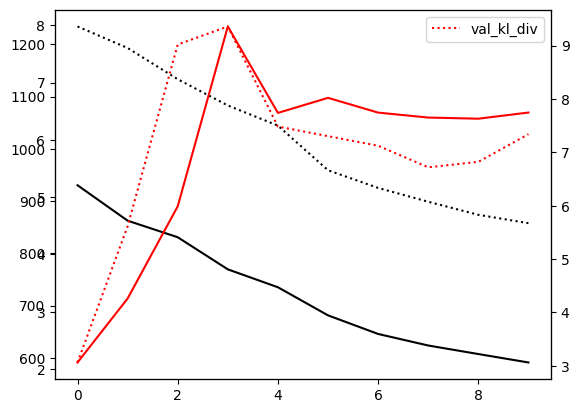

In [77]:
plt.plot(history.history["reconstruction_loss"], c='k', label='reconstruction')
plt.plot(history.history["val_reconstruction_loss"], c='k', linestyle=':', label='val_reconstruction')

plt.gca().twinx().plot(history.history["kl_loss"], c='r', label='kl_div')
plt.gca().twinx().plot(history.history["val_kl_loss"], c='r', linestyle=':', label='val_kl_div')

plt.legend()
plt.show()